$$
\def\CC{\bf C}
\def\QQ{\bf Q}
\def\RR{\bf R}
\def\ZZ{\bf Z}
\def\NN{\bf N}
$$
# RL Intro

In a nutshell, RL is the study of agents and how they learn by trial and error. It formalizes the idea that rewarding or punishing an agent for its behavior makes it more likely to repeat or forego that behavior in the future.

## What Can RL Do?

RL methods have recently enjoyed a wide variety of successes. For example, it's been used to teach computers to control robots in simulation...

<video autoplay="" src="https://d4mucfpksywv.cloudfront.net/openai-baselines-ppo/knocked-over-stand-up.mp4" loop="" controls="" style="display: block; margin-left: auto; margin-right: auto; margin-bottom:1.5em; width: 100%; max-width: 720px; max-height: 80vh;">
</video>

## Key Concepts and Terminology

![Agent-environment interaction loop.](images/rl_diagram_transparent_bg.png)

The main characters of RL are the **agent** and the **environment**. The environment is the world that the agent lives in and interacts with. At every step of interaction, the agent sees a (possibly partial) observation of the state of the world, and then decides on an action to take. The environment changes when the agent acts on it, but may also change on its own.

The agent also perceives a **reward** signal from the environment, a number that tells it how good or bad the current world state is. The goal of the agent is to maximize its cumulative reward, called **return**. Reinforcement learning methods are ways that the agent can learn behaviors to achieve its goal.


### States and Observations

A **state** $s$ is a complete description of the state of the world. There is no information about the world which is hidden from the state. An **observation** $o$ is a partial description of a state, which may omit information.

In deep RL, we almost always represent states and observations by a [real-valued vector, matrix, or higher-order tensor](). For instance, a visual observation could be represented by the RGB matrix of its pixel values; the state of a robot might be represented by its joint angles and velocities.

When the agent is able to observe the complete state of the environment, we say that the environment is **fully observed**. When the agent can only see a partial observation, we say that the environment is **partially observed**.


### Action Spaces

Different environments allow different kinds of actions. The set of all valid actions in a given environment is often called the **action space**. Some environments, like Atari and Go, have **discrete action spaces**, where only a finite number of moves are available to the agent. Other environments, like where the agent controls a robot in a physical world, have **continuous action spaces**. In continuous spaces, actions are real-valued vectors.

This distinction has some quite-profound consequences for methods in deep RL. Some families of algorithms can only be directly applied in one case, and would have to be substantially reworked for the other.

### Policies

A **policy** is a rule used by an agent to decide what actions to take. It can be deterministic, in which case it is usually denoted by $\mu$ :

$$a_t = \mu(s_t),$$

or it may be stochastic, in which case it is usually denoted by $\pi$ :

$$a_t \sim \pi(\cdot | s_t).$$

Because the policy is essentially the agent's brain, it's not uncommon to substitute the word "policy" for "agent", eg saying "The policy is trying to maximize reward."

In deep RL, we deal with **parameterized policies**: policies whose outputs are computable functions that depend on a set of parameters (eg the weights and biases of a neural network) which we can adjust to change the behavior via some optimization algorithm.

We often denote the parameters of such a policy by $\theta$ or $\phi$, and then write this as a subscript on the policy symbol to highlight the connection:

$$a_t = \mu_{\theta}(s_t)$$

$$a_t \sim \pi_{\theta}(\cdot | s_t).$$




#### Stochastic Policies

The two most common kinds of stochastic policies in deep RL are **categorical policies** and **diagonal Gaussian policies**.

[Categorical]() policies can be used in discrete action spaces, while diagonal [Gaussian]() policies are used in continuous action spaces.

Two key computations are centrally important for using and training stochastic policies:

-   sampling actions from the policy,
-   and computing log likelihoods of particular actions, $\log \pi_{\theta}(a|s)$.

In what follows, we'll describe how to do these for both categorical and diagonal Gaussian policies.

Categorical Policies

A categorical policy is like a classifier over discrete actions. You build the neural network for a categorical policy the same way you would for a classifier: the input is the observation, followed by some number of layers (possibly convolutional or densely-connected, depending on the kind of input), and then you have one final linear layer that gives you logits for each action, followed by a [softmax]() to convert the logits into probabilities.

**Sampling.** Given the probabilities for each action, frameworks like Tensorflow have built-in tools for sampling. For example, see the [tf.distributions.Categorical]() documentation, or [tf.multinomial]().

**Log-Likelihood.** Denote the last layer of probabilities as $P_{\theta}(s)$. It is a vector with however many entries as there are actions, so we can treat the actions as indices for the vector. The log likelihood for an action $a$ can then be obtained by indexing into the vector:

$$\log \pi_{\theta}(a|s) = \log \left[P_{\theta}(s)\right]_a.$$

Diagonal Gaussian Policies

A multivariate Gaussian distribution (or multivariate normal distribution, if you prefer) is described by a mean vector, $\mu$, and a covariance matrix, $\Sigma$. A diagonal Gaussian distribution is a special case where the covariance matrix only has entries on the diagonal. As a result, we can represent it by a vector.

A diagonal Gaussian policy always has a neural network that maps from observations to mean actions, $\mu_{\theta}(s)$. There are two different ways that the covariance matrix is typically represented.

**The first way:** There is a single vector of log standard deviations, $\log \sigma$, which is **not** a function of state: the $\log \sigma$ are standalone parameters. (You Should Know: our implementations of VPG, TRPO, and PPO do it this way.)

**The second way:** There is a neural network that maps from states to log standard deviations, $\log \sigma_{\theta}(s)$. It may optionally share some layers with the mean network.

Note that in both cases we output log standard deviations instead of standard deviations directly. This is because log stds are free to take on any values in $(-\infty, \infty)$, while stds must be nonnegative. It's easier to train parameters if you don't have to enforce those kinds of constraints. The standard deviations can be obtained immediately from the log standard deviations by exponentiating them, so we do not lose anything by representing them this way.

**Sampling.** Given the mean action $\mu_{\theta}(s)$ and standard deviation $\sigma_{\theta}(s)$, and a vector $z$ of noise from a spherical Gaussian ($z \sim \mathcal{N}(0, I)$), an action sample can be computed with

$$a = \mu_{\theta}(s) + \sigma_{\theta}(s) \odot z,$$

where $\odot$ denotes the elementwise product of two vectors. Standard frameworks have built-in ways to compute the noise vectors, such as [tf.random\_normal](). Alternatively, you can just provide the mean and standard deviation directly to a [tf.distributions.Normal]() object and use that to sample.

**Log-Likelihood.** The log-likelihood of a $k$ -dimensional action $a$, for a diagonal Gaussian with mean $\mu = \mu_{\theta}(s)$ and standard deviation $\sigma = \sigma_{\theta}(s)$, is given by

$$\log \pi_{\theta}(a|s) = -\frac{1}{2}\left(\sum_{i=1}^k \left(\frac{(a_i - \mu_i)^2}{\sigma_i^2} + 2 \log \sigma_i \right) + k \log 2\pi \right).$$

### Trajectories

A trajectory $\tau$ is a sequence of states and actions in the world,

$$\tau = (s_0, a_0, s_1, a_1, ...).$$

The very first state of the world, $s_0$, is randomly sampled from the **start-state distribution**, sometimes denoted by $\rho_0$ :

$$s_0 \sim \rho_0(\cdot).$$

State transitions (what happens to the world between the state at time $t$, $s_t$, and the state at $t+1$, $s_{t+1}$), are governed by the natural laws of the environment, and depend on only the most recent action, $a_t$. They can be either deterministic,

$$s_{t+1} = f(s_t, a_t)$$

or stochastic,

$$s_{t+1} \sim P(\cdot|s_t, a_t).$$

Actions come from an agent according to its policy.



### Reward and Return

The reward function $R$ is critically important in reinforcement learning. It depends on the current state of the world, the action just taken, and the next state of the world:

$$r_t = R(s_t, a_t, s_{t+1})$$

although frequently this is simplified to just a dependence on the current state, $r_t = R(s_t)$, or state-action pair $r_t = R(s_t,a_t)$.

The goal of the agent is to maximize some notion of cumulative reward over a trajectory, but this actually can mean a few things. We'll notate all of these cases with $R(\tau)$, and it will either be clear from context which case we mean, or it won't matter (because the same equations will apply to all cases).

One kind of return is the **finite-horizon undiscounted return**, which is just the sum of rewards obtained in a fixed window of steps:

$$R(\tau) = \sum_{t=0}^T r_t.$$

Another kind of return is the **infinite-horizon discounted return**, which is the sum of all rewards *ever* obtained by the agent, but discounted by how far off in the future they're obtained. This formulation of reward includes a discount factor $\gamma \in (0,1)$ :

$$R(\tau) = \sum_{t=0}^{\infty} \gamma^t r_t.$$

Why would we ever want a discount factor, though? Don't we just want to get *all* rewards? We do, but the discount factor is both intuitively appealing and mathematically convenient. On an intuitive level: cash now is better than cash later. Mathematically: an infinite-horizon sum of rewards [may not converge]() to a finite value, and is hard to deal with in equations. But with a discount factor and under reasonable conditions, the infinite sum converges.


### The RL Problem

Whatever the choice of return measure (whether infinite-horizon discounted, or finite-horizon undiscounted), and whatever the choice of policy, the goal in RL is to select a policy which maximizes **expected return** when the agent acts according to it.

To talk about expected return, we first have to talk about probability distributions over trajectories.

Let's suppose that both the environment transitions and the policy are stochastic. In this case, the probability of a $T$ -step trajectory is:

$$P(\tau|\pi) = \rho_0 (s_0) \prod_{t=0}^{T-1} P(s_{t+1} | s_t, a_t) \pi(a_t | s_t).$$

The expected return (for whichever measure), denoted by $J(\pi)$, is then:

$$J(\pi) = \int_{\tau} P(\tau|\pi) R(\tau) = E_{\tau\sim \pi}{R(\tau)}.$$



The central optimization problem in RL can then be expressed by

$$\pi^* = \arg \max_{\pi} J(\pi),$$

with $\pi^*$ being the **optimal policy**.

### Value Functions

It's often useful to know the **value** of a state, or state-action pair. By value, we mean the expected return if you start in that state or state-action pair, and then act according to a particular policy forever after. **Value functions** are used, one way or another, in almost every RL algorithm.

There are four main functions of note here.

1.  The **On-Policy Value Function**, $V^{\pi}(s)$, which gives the expected return if you start in state $s$ and always act according to policy $\pi$ :


$$V^{\pi}(s) = E_{\tau \sim \pi}{R(\tau)\left| s_0 = s\right.}$$


2.  The **On-Policy Action-Value Function**, $Q^{\pi}(s,a)$, which gives the expected return if you start in state $s$, take an arbitrary action $a$ (which may not have come from the policy), and then forever after act according to policy $\pi$ :


$$Q^{\pi}(s,a) = E_{\tau \sim \pi}{R(\tau)\left| s_0 = s, a_0 = a\right.}$$


3.  The **Optimal Value Function**, $V^*(s)$, which gives the expected return if you start in state $s$ and always act according to the *optimal* policy in the environment:


$$V^*(s) = \max_{\pi} E_{\tau \sim \pi}{R(\tau)\left| s_0 = s\right.}$$


4.  The **Optimal Action-Value Function**, $Q^*(s,a)$, which gives the expected return if you start in state $s$, take an arbitrary action $a$, and then forever after act according to the *optimal* policy in the environment:

$$Q^*(s,a) = \max_{\pi} E_{\tau \sim \pi}{R(\tau)\left| s_0 = s, a_0 = a\right.}$$



You Should Know

There are two key connections between the value function and the action-value function that come up pretty often:

$$V^{\pi}(s) = E_{a\sim \pi}{Q^{\pi}(s,a)},$$

and

$$V^*(s) = \max_a Q^* (s,a).$$

These relations follow pretty directly from the definitions just given: can you prove them?

### The Optimal Q-Function and the Optimal Action

There is an important connection between the optimal action-value function $Q^*(s,a)$ and the action selected by the optimal policy. By definition, $Q^*(s,a)$ gives the expected return for starting in state $s$, taking (arbitrary) action $a$, and then acting according to the optimal policy forever after.

The optimal policy in $s$ will select whichever action maximizes the expected return from starting in $s$. As a result, if we have $Q^*$, we can directly obtain the optimal action, $a^*(s)$, via

$$a^*(s) = \arg \max_a Q^* (s,a).$$

Note: there may be multiple actions which maximize $Q^*(s,a)$, in which case, all of them are optimal, and the optimal policy may randomly select any of them. But there is always an optimal policy which deterministically selects an action.

### Bellman Equations

All four of the value functions obey special self-consistency equations called **Bellman equations**. The basic idea behind the Bellman equations is this:

> The value of your starting point is the reward you expect to get from being there, plus the value of wherever you land next.

The Bellman equations for the on-policy value functions are

$$\begin{align*}
V^{\pi}(s) = E_{a \sim \pi \\ s'\sim P}{r(s,a) + \gamma V^{\pi}(s')}, \\
Q^{\pi}(s,a) = E_{s'\sim P}{r(s,a) + \gamma E_{a'\sim \pi}{Q^{\pi}(s',a')}},
\end{align*}$$

where $s' \sim P$ is shorthand for $s' \sim P(\cdot |s,a)$, indicating that the next state $s'$ is sampled from the environment's transition rules; $a \sim \pi$ is shorthand for $a \sim \pi(\cdot|s)$; and $a' \sim \pi$ is shorthand for $a' \sim \pi(\cdot|s')$.

The Bellman equations for the optimal value functions are

$$\begin{align*}
V^*(s) &= \max_a E_{s'\sim P}{r(s,a) + \gamma V^*(s')}, \\
Q^*(s,a) &= E_{s'\sim P}{r(s,a) + \gamma \max_{a'} Q^*(s',a')}.
\end{align*}$$

The crucial difference between the Bellman equations for the on-policy value functions and the optimal value functions, is the absence or presence of the $\max$ over actions. Its inclusion reflects the fact that whenever the agent gets to choose its action, in order to act optimally, it has to pick whichever action leads to the highest value.

You Should Know

The term "Bellman backup" comes up quite frequently in the RL literature. The Bellman backup for a state, or state-action pair, is the right-hand side of the Bellman equation: the reward-plus-next-value.

### Advantage Functions

Sometimes in RL, we don't need to describe how good an action is in an absolute sense, but only how much better it is than others on average. That is to say, we want to know the relative **advantage** of that action. We make this concept precise with the **advantage function.**

The advantage function $A^{\pi}(s,a)$ corresponding to a policy $\pi$ describes how much better it is to take a specific action $a$ in state $s$, over randomly selecting an action according to $\pi(\cdot|s)$, assuming you act according to $\pi$ forever after. Mathematically, the advantage function is defined by

$$A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s).$$


## Multi-armed bandit

The simplest reinforcement learning problem is the multi-armed bandit. Essentially, there are $n$-many slot machines, each with a different fixed payout probability. 

The goal is to discover the machine with the best payout, and maximize the returned reward by always choosing it. 

<img src="images/slot.jpg" alt="" style="width: 400px;"/>

This question has been the subject of active research since the 1950s, and many variations have been studied.

#### A-B Testing

Traditional A-B testing can be thought of as a special case of the multi-armed bandit problem, in which we choose to pursue a strategy of pure exploration in the initial testing phase, followed by a period of pure exploitation in which we choose the most valuable “arm” 100% of the time.

If the exploitation phase can be assumed to be much longer than the exploration phase, this approach is usually reasonable, as the wasted resources during the exploration are insignificant relative to the total rewards. However, in cases where the cost of the exploration phase is non-negligible, or in cases in which arm values are changing dynamically on short enough timescales that it becomes impractical to repeatedly perform new A-B tests, alternative approaches are needed.

The n-armed bandit is a nice starting place because we don’t have to worry about aspects #2 and #3. All we need to focus on is learning which rewards we get for each of the possible actions, and ensuring we chose the optimal ones.

### Epsilon-greedy

The most straightforward algorithm for continuously balancing exploration with exploitation is called “epsilon-greedy”. 

Here, we pull a randomly chosen arm a fraction $\epsilon$ of the time. The other $1-\epsilon$ of the time, we pull the arm which we estimate to be the most profitable. As each arm is pulled and rewards are received, our estimates of arm values are updated. 

This method can be thought of a a continuous testing setup, where we devote a fraction $\epsilon$ of our resources to testing.

The following python code implements a simple 10-Armed Bandit using the epsilon-greedy algorithm. 

The payout rate of the arms are normally distributed with $\mu = 0$ and $\sigma = 1$. Gaussian noise is also added to the rewards, also with $\mu = 0$ and $\sigma = 1$. (See [Sutton and Barto](http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf) book, section 2.1)

Although ε-greedy action selection is an effective and popular means of balancing exploration and exploitation in reinforcement learning, one drawback is that when it explores **it chooses equally among all actions**. 

This means that it is as likely to choose the worst-appearing action as it is to choose the next-to-best action. In tasks where the worst actions are very bad, this may
be unsatisfactory. The obvious solution is to vary the action probabilities as a graded function of estimated value.

The greedy action will be given the highest selection probability, but all the others will be ranked and weighted according to
their value estimates. To this end we can use a softmax action selection rule (with a temperature parameter $\tau$):

$$
\frac{ e^{Q_t(a)/ \tau}}{\sum_{i=1}^n e^{Q_t(i)/ \tau}}
$$

For high temperatures ( $\tau \to \infty $ ), all actions have nearly the same probability. For a low temperature ( $ \tau \to 0^{+} $), the probability of the action with the highest expected reward tends to 1.

In [5]:
import numpy as np 
import seaborn 
from tqdm import tqdm

class Bandit: 
    def __init__(self): 
        self.arm_values = np.random.normal(0,1,10) 
        self.K = np.zeros(10) 
        self.est_values = np.zeros(10) 

    def get_reward(self,action): 
        noise = np.random.normal(0,1) 
        reward = self.arm_values[action] + noise 
        return reward 

    def choose_eps_greedy(self,epsilon):
        rand_num = np.random.random() 
        if epsilon>rand_num: 
            return np.random.randint(10) 
        else: 
            return np.argmax(self.est_values)

    def update_est(self,action,reward): 
        self.K[action] += 1 
        alpha = 1./self.K[action] 
        self.est_values[action] += alpha * (reward - self.est_values[action]) 

How are we estimating the value of an action?

If by the $t$-th time step action $a$ has been chosen $K_a$ times prior to $t$, yielding rewards 
$R_1, R_2, . . . , R_{Ka}$, then its value is estimated to be:

$$
Q_t(a) = \frac{R_1 + R_2 + . . .+ R_{Ka}}{K_a}
$$

A problem with this straightforward implementation is that its memory and computational requirements grow over time without
bound (we have to maintain, for each action $a$, a record of all the rewards that have followed the
selection of that action), but we can derive an incremental formula for computing averages with small, constant computation
required to process each new reward.

\begin{eqnarray*}
Q_{k+1} & = & \frac{1}{k+1} \sum_{i=1}^{k+1} R_i \\
  & = & \frac{1}{k+1} \left( R_{k+1} + \sum_{i=1}^k R_i
\right) \\
  & = & \frac{1}{k+1} \left( R_{k+1} + kQ_k + Q_k - Q_k
\right) \\
  & = & \frac{1}{k+1} \left(R_{k+1} + (k+1) Q_k - Q_k
\right) \\
  & = & Q_k + \frac{1}{k+1} \left( R_{k+1} - Q_k \right)
\end{eqnarray*}



In [6]:
def experiment(bandit,Npulls,epsilon):
    history = [] 
    for i in range(Npulls): 
        action = bandit.choose_eps_greedy(epsilon)
        R = bandit.get_reward(action) 
        bandit.update_est(action,R) 
        history.append(R) 
    return np.array(history)

Let's make three different experiments: $\epsilon = 0$, $\epsilon = 0.1$ and $\epsilon = 0.01$. Data will be averages over 2000 tasks.

100%|██████████| 2000/2000 [03:14<00:00,  9.78it/s]


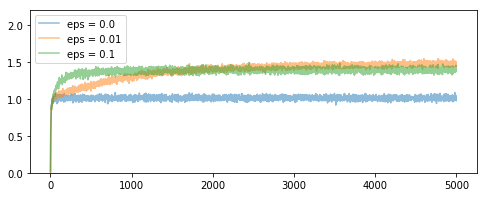

In [8]:
Nexp = 2000
Npulls = 5000 
avg_outcome_eps0p0 = np.zeros(Npulls) 
avg_outcome_eps0p01 = np.zeros(Npulls) 
avg_outcome_eps0p1 = np.zeros(Npulls) 

for i in tqdm(range(Nexp)): 
    bandit = Bandit() 
    avg_outcome_eps0p0 += experiment(bandit,Npulls,0.0) 
    bandit = Bandit() 
    avg_outcome_eps0p01 += experiment(bandit,Npulls,0.01) 
    bandit = Bandit() 
    avg_outcome_eps0p1 += experiment(bandit,Npulls,0.1) 

avg_outcome_eps0p0 /= np.float(Nexp) 
avg_outcome_eps0p01 /= np.float(Nexp) 
avg_outcome_eps0p1 /= np.float(Nexp) 

# plot results 
import matplotlib.pyplot as plt 

plt.plot(avg_outcome_eps0p0,label="eps = 0.0", alpha=0.5) 
plt.plot(avg_outcome_eps0p01,label="eps = 0.01", alpha=0.5) 
plt.plot(avg_outcome_eps0p1,label="eps = 0.1", alpha=0.5) 
plt.ylim(0,2.2) 
plt.legend() 
plt.gcf().set_size_inches((8,3))
plt.show()

## Q-learning

Unlike other methods, which attempt to learn functions which directly map an observation to an action, Q-Learning attempts **to learn the value of being in a given state, and taking a specific action there**. 

The agent is in a state $s$ and has to choose one action $a$, upon which it receives a reward $r$ and come to a new state $s’$. The way the agent chooses actions is called **policy**.

Let’s define a function $Q(s, a)$ such that for given state $s$ and action $a$ it returns an estimate of a total reward we would achieve starting at this state, taking the action and then following some policy. Under certain conditions, there certainly exist policies that are optimal, meaning that they always select an action which is the best in the context. Let’s call the $Q$ function for these optimal policies $Q^*$.

If we knew the true $Q^*$ function, the solution would be straightforward. We would just apply a greedy policy to it. That means that in each state $s$, we would just choose an action $a$ that maximizes the function $Q^*$, $argmax_a Q^*(s, a)$. Knowing this, our problem reduces to find a good estimate of the $Q^*$ function and apply the greedy policy to it.

Let’s write a formula for this function in a symbolic way. It is a sum of rewards we achieve after each action, but we will discount every member with γ:

 $$ Q^*(s, a) = r_0 + \gamma r_1 + \gamma^2 r_2 + \gamma^3 r_3 + ... $$

$\gamma$ is called a discount factor and when set it to $\gamma < 1$ , it makes sure that the sum in the formula is finite. Value of each member exponentially diminish as they are more and more in the future and become zero in the limit. The $\gamma$ therefore controls how much the function $Q$ in state $s$ depends on the future and so it can be thought of as how much ahead the agent sees. 

Typically we set it to a value close, but lesser to one. The actions are chosen according to the greedy policy, maximizing the $Q^*$ function.

When we look again at the formula, we see that we can write it in a recursive form:

 $$Q^*(s, a) = r_0 + \gamma (r_1 + \gamma r_2 + \gamma^2 r_3 + ...) = r_0 + \gamma max_a Q^*(s', a)$$
 
We just derived a so called **Bellman equation**.
 
One of the possible strategies to solve the Bellman equation is by applying the **Q-learning** algorithm:

```
For each state-action pair (s, a), initialize the table entry Q(s,a) to zero
Observe the current state s
Do forever:
- Select an action a from s and execute it 
- Receive immediate reward r
- Observe the new state s'
- Update the table entry for Q
- s=s'
```
#### Action selection

We could apply different strategies for action selection:
+ **Random approach**. Only in circumstances where a random policy is optimal would this approach be ideal.
+ **$\epsilon$- greedy approach**:  A simple combination of the greedy and random approaches yields one of the most used exploration strategies. At the start of the training process the $\epsilon$ value is often initialized to a large probability, to encourage exploration in the face of knowing little about the environment. The value is then annealed down to a small constant (often 0.1), as the agent is assumed to learn most of what it needs about the environment. Despite the prevalence of usage that it enjoys, this method is far from optimal, since it takes into account only whether actions are most rewarding or not.
+ **Boltzmann Approach**. Instead of always taking the optimal action, or taking a random action, this approach involves choosing an action with weighted probabilities. To accomplish this we use a softmax over the networks estimates of value for each action.  In practice we utilize an additional temperature parameter ($\tau$) which is annealed over time. While this measure can be a useful proxy, it is not exactly what would best aid exploration. What we really want to understand is the agent’s uncertainty about the value of different actions.
+ **Bayesian Approaches**. What if an agent could exploit its own uncertainty about its actions? This is exactly the ability that a class of neural network models referred to as Bayesian Neural Networks (BNNs) provide. Unlike traditional neural network which act deterministically, BNNs act probabilistically. This means that instead of having a single set of fixed weights, a BNN maintains a probability distribution over possible weights. In a reinforcement learning setting, the distribution over weight values allows us to obtain distributions over actions as well. The variance of this distribution provides us an estimate of the agent’s uncertainty about each action. In order to get true uncertainty estimates, multiple samples are required, thus increasing computational complexity.


#### Table updating

The table entry for $Q$ is updated by using this formula:

$$
Q(s,a) = Q(s,a) + \alpha [r + \gamma max_{a'} Q(s',a') - Q(s,a) ]
$$

where 

+ $0<\alpha<1$ is the learning rate. Setting it to 0 means that the Q-values are never updated, hence nothing is learned. Setting a high value such as 0.9 means that learning can occur quickly.
+ $0<\gamma<1$ is the discount factor. This models the fact that future rewards are worth less than immediate rewards. 

See http://www.scholarpedia.org/article/Temporal_difference_learning for a short description.

### Solving the FrozenLake problem

We are going to to solve the FrozenLake environment from the OpenAI gym. 

OpenAI gym (https://gym.openai.com/) provides an easy way for people to experiment with their learning agents in an array of provided toy games. The FrozenLake environment consists of a 4x4 grid of blocks, each one either being the start block, the goal block, a safe frozen block, or a dangerous hole. 

> **FrozenLake-v0**

> The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

> The surface is described using a grid like the following:

>``SFFF       (S: starting point, safe)``

>``FHFH       (F: frozen surface, safe)``

>``FFFH       (H: hole, fall to your doom)``

>``HFFG       (G: goal, where the frisbee is located)``

> The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

The objective is to have an agent learn to navigate from the start to the goal without moving onto a hole. At any given time the agent can choose to move either ``up, down, left``, or ``right``. 

The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose. As such, perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. 

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a $16 \times 4$ table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

In [3]:
import tensorflow
tensorflow.__version__

'1.13.1'

In [ ]:
!pip install --upgrade pip
!pip install gym

In [9]:
import gym
import numpy as np
env = gym.make('FrozenLake-v0')

In [10]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])

# Set learning parameters
lr = .9
gamma = 0.95
num_episodes = 10000

#create lists to contain total rewards and steps per episode
rList = []

for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    
    #The Q-Table learning algorithm
    while j < 999999:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + gamma*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    rList.append(rAll)

FrozenLake-v0 is considered "solved" when the agent obtains an average reward of at least 0.78 over 100 consecutive episodes.

In [11]:
print("Score over time: " +  str(sum(rList[-100:])/100))
print("Final Q-Table Values")
print(Q)

Score over time: 0.56
Final Q-Table Values
[[2.39278400e-01 1.03695832e-03 1.09679898e-03 1.03375717e-03]
 [1.11555916e-05 1.25546279e-05 1.18256725e-04 2.97833059e-01]
 [8.58555556e-04 1.10888860e-04 3.24661929e-04 2.13220715e-01]
 [1.13533416e-05 7.68274654e-04 1.36421941e-05 3.33458488e-02]
 [1.52376885e-01 3.07694138e-05 1.35127572e-05 1.27524297e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.04404437e-04 5.44203580e-05 9.15082942e-05 5.03739627e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.75596538e-06 4.43157862e-05 6.02790258e-05 6.97470053e-01]
 [3.82319572e-05 2.90784559e-01 5.93252462e-05 1.20300519e-05]
 [6.54414096e-03 9.96999673e-07 8.71046068e-05 2.05422670e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.43340473e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.05527611e-01 1.06416500e-03]
 [0.00000000